In [8]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [9]:
def plot_graphs(history, string):
      plt.plot(history.history[string])
      plt.plot(history.history['val_'+string])
      plt.xlabel("Epochs")
      plt.ylabel(string)
      plt.legend([string, 'val_'+string])
      plt.show()

In [16]:
def category_predict(quest):
    vocab_size = 7000
    embedding_dim = 256
    max_length = 15
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    
    stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "while", "with", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]
    punctuations = '''!()-[]{};:'"`\,<>./?@#$%^&*_~\n'''
    
    train_category = []
    train_subcategory = []
    train_questions = []

    with open('train_5500.label', 'r') as f:
        for line in f:
            split_index1 = line.index(":")
            split_index2 = line.index(" ")
            train_category.append(line[:split_index1])
            train_subcategory.append(line[split_index1+1:split_index2])
            train_questions.append(line[(split_index2+1):])
            
    for i in range(0,len(train_questions)):
        train_question = train_questions[i].lower()
        for word in stopwords:
            token = " " + word + " "
            train_question = train_question.replace(token, " ")
        no_punct = ''
        for char in train_question:
            if char not in punctuations:
                no_punct = no_punct + char
        no_punct = no_punct.replace("  ", " ")
        train_questions[i] = no_punct
    
    test_category = []
    test_subcategory = []
    test_questions = []

    with open('TREC_10.label', 'r') as f:
        for line in f:
            split_index1 = line.index(":")
            split_index2 = line.index(" ")
            test_category.append(line[:split_index1])
            test_subcategory.append(line[split_index1+1:split_index2])
            test_questions.append(line[(split_index2+1):])
    
    for i in range(0,len(test_questions)):
        test_question = test_questions[i].lower()
        for word in stopwords:
            token = " " + word + " "
            test_question = test_question.replace(token, " ")
        no_punct = ''
        for char in test_question:
            if char not in punctuations:
                no_punct = no_punct + char
        no_punct = no_punct.replace("  ", " ")
        test_questions[i] = no_punct

    ques=[]
    for i in range(0,len(quest)):
        ques1 = quest[i].lower()
        for word in stopwords:
            token = " " + word + " "
            ques1 = ques1.replace(token, " ")
        no_punct = ''
        for char in ques1:
            if char not in punctuations:
                no_punct = no_punct + char
        no_punct = no_punct.replace("  ", " ")
        ques.append(no_punct)
    
    tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
    tokenizer.fit_on_texts(train_questions)
    word_index = tokenizer.word_index
#     print(word_index)

    train_sequences = tokenizer.texts_to_sequences(train_questions)
    train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
    
    test_sequences = tokenizer.texts_to_sequences(test_questions)
    test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
#     print(test_sequences)
    
    ques_sequences = tokenizer.texts_to_sequences(ques)
    ques_padded = pad_sequences(ques_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
    
    category_tokenizer = Tokenizer()
    category_tokenizer.fit_on_texts(train_category)
    category_word_index = category_tokenizer.word_index

    train_category_seq = pad_sequences(np.array(category_tokenizer.texts_to_sequences(train_category)), maxlen=1)
    test_category_seq = pad_sequences(np.array(category_tokenizer.texts_to_sequences(test_category)), maxlen=1)
    
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(32)),
        keras.layers.Dense(64, activation = 'relu'),
        keras.layers.Dense(32, activation = 'sigmoid'),
        keras.layers.Dense(7, activation = 'softmax')])

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr=0.002), metrics=['acc'])
    #model.summary()
    
    num_epochs = 10
    history = model.fit(train_padded, train_category_seq, epochs = num_epochs, validation_data=(test_padded, test_category_seq), verbose = 2)

    plot_graphs(history, "acc")
    plot_graphs(history, "loss")
    
    prediction = model.predict(ques_padded)
    print(ques)
#     print(ques_sequences)
#     print(ques_padded)
#     print(prediction)
#     print(category_word_index)
    category_predicted=[]
    for i in prediction:
#     x = i.find(max(i))
        x = (np.where(i == np.amax(i)))[0]
    #     print(x)
        for a in category_word_index:
            if category_word_index[a] == x:
                print(a)
                category_predicted.append(x)
                
                
    subcategory_tokenizer = Tokenizer()
    subcategory_tokenizer.fit_on_texts(train_subcategory)
    subcategory_word_index = subcategory_tokenizer.word_index
#     print(subcategory_word_index)

    train_subcategory_seq = pad_sequences(np.array(subcategory_tokenizer.texts_to_sequences(train_subcategory)), maxlen=1)
    test_subcategory_seq = pad_sequences(np.array(subcategory_tokenizer.texts_to_sequences(test_subcategory)), maxlen=1)
    
    model1 = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.GRU(96, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(64)),
    #     tf.keras.layers.Dropout(0.2),
    #     tf.keras.layers.GlobalAveragePooling1D(),
    #     tf.keras.layers.Dense(120, activation = 'relu'),
        keras.layers.Dense(64, activation = 'sigmoid'),
        keras.layers.Dense(48, activation = 'softmax')
    ])

    model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
#     model1.summary()

    num_epochs = 20
    history1 = model1.fit((train_padded, train_category_seq), train_subcategory_seq, epochs = num_epochs, validation_data=((test_padded, test_category_seq), test_subcategory_seq), verbose = 2)
  
    plot_graphs(history1, "acc")
    plot_graphs(history1, "loss")
    
    sub_prediction = model1.predict((ques_padded, category_predicted))
    print(subcategory_word_index)
    for i in sub_prediction:
        x = (np.where(i == np.amax(i)))[0]
        print(x)
        for a in subcategory_word_index:
            if subcategory_word_index[a] == x:
                print(a)

#     print(validation_subcategory_seq[-10:])
#     print(validation_questions[-10:])

Train on 5452 samples, validate on 500 samples
Epoch 1/10
5452/5452 - 41s - loss: 1.1317 - acc: 0.5890 - val_loss: 0.6541 - val_acc: 0.8000
Epoch 2/10
5452/5452 - 16s - loss: 0.4565 - acc: 0.8723 - val_loss: 0.5356 - val_acc: 0.8500
Epoch 3/10
5452/5452 - 16s - loss: 0.2476 - acc: 0.9376 - val_loss: 0.6678 - val_acc: 0.8320
Epoch 4/10
5452/5452 - 15s - loss: 0.1720 - acc: 0.9580 - val_loss: 0.7537 - val_acc: 0.7800
Epoch 5/10
5452/5452 - 15s - loss: 0.1272 - acc: 0.9694 - val_loss: 0.7158 - val_acc: 0.8180
Epoch 6/10
5452/5452 - 15s - loss: 0.0930 - acc: 0.9776 - val_loss: 0.6161 - val_acc: 0.8620
Epoch 7/10
5452/5452 - 15s - loss: 0.0699 - acc: 0.9839 - val_loss: 0.6304 - val_acc: 0.8460
Epoch 8/10
5452/5452 - 15s - loss: 0.0518 - acc: 0.9899 - val_loss: 0.7105 - val_acc: 0.8220
Epoch 9/10
5452/5452 - 16s - loss: 0.0385 - acc: 0.9921 - val_loss: 0.7653 - val_acc: 0.8200
Epoch 10/10
5452/5452 - 15s - loss: 0.0390 - acc: 0.9912 - val_loss: 0.7524 - val_acc: 0.8460


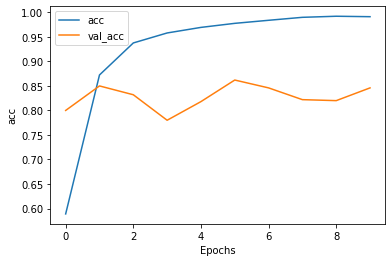

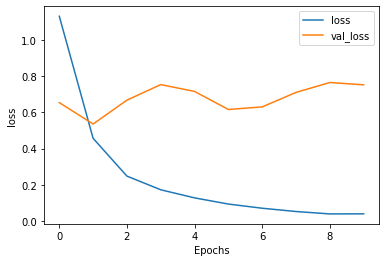

['who bill gates ', 'where mumbai located ', 'what schrodinger s cat ', 'can earth planet ', 'how long take dance ']
hum
loc
desc
desc
num
Train on 5452 samples, validate on 500 samples
Epoch 1/20
5452/5452 - 44s - loss: 3.0482 - acc: 0.2051 - val_loss: 2.7098 - val_acc: 0.4660
Epoch 2/20


In [ ]:
category_predict(["Who was Bill Gates ?", "Where is Mumbai located ?", "What is Schrodinger 's cat ?", "Can earth be a planet ?", "How long does it take to dance ?"])

In [ ]:
category_predict(["Who was Bill Gates ?", "Where is Mumbai located ?", "What is Schrodinger 's cat ?", "Can earth be a planet ?", "How long does it take to dance ?"])